# Managing Files

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob as g
import shutil
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.models as models

In [2]:
from IPython.display import clear_output
!pip install --upgrade kaggle
clear_output()
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [3]:
!rm -rf "/content/sample_data"
!rm -rf "/content/Images"
!rm -rf "/content/caption.txt"
!rm -rf "/content/flickr8k.zip"

In [6]:
!kaggle datasets download -d adityajn105/flickr8k

 98% 1.01G/1.04G [00:03<00:00, 288MB/s]
100% 1.04G/1.04G [00:03<00:00, 281MB/s]


In [7]:
!unzip -q '/content//flickr8k.zip';

In [5]:
test_size = 1000

In [8]:
df = pd.read_csv('captions.txt')
train_df = df.iloc[:-test_size*5].reset_index()
train_df.drop('index', axis=1, inplace=True)
test_df = df.iloc[-test_size*5:].reset_index()
test_df.drop('index', axis=1, inplace=True)

In [9]:
os.mkdir('/content/images/')
os.mkdir('/content/images/test/')
os.mkdir('/content/images/train/')

In [10]:
all_images_path = g('/content/Images/*')
all_images_path = sorted(all_images_path)

train_images_path = all_images_path[:-test_size]
test_images_path = all_images_path[-test_size:]

In [11]:
for i in range(len(train_images_path)):
  dst_path = os.path.join('/content/images/train/' + train_images_path[i].split('/')[-1])
  shutil.move(train_images_path[i], dst_path)

for i in range(len(test_images_path)):
  dst_path = os.path.join('/content/images/test/' + test_images_path[i].split('/')[-1])
  shutil.move(test_images_path[i], dst_path)

# PreProccesing & Dataset

In [17]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import spacy
from PIL import Image
from torchvision.transforms import transforms

In [18]:
filter_dict = {33:  None, 34:  None, 35:  None, 36:  None, 37:  None, 63:  None,
               40:  None, 41:  None, 44:  None, 45:  32, 46:  None, 58:  None} #ascii format of puntuations to filter .,!?#()"

In [19]:
def filter_puntuation(caption):
  return caption.lower().translate(filter_dict)

In [20]:
test_df['caption'] = test_df['caption'].apply(filter_puntuation)
train_df['caption'] = train_df['caption'].apply(filter_puntuation)

In [21]:
spacy_eng = spacy.load("en_core_web_sm")
stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<OOV>": 3}
itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<OOV>"}

In [22]:
import torchtext
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")

In [23]:
tokenizer("You can now, install TorchText using pip!")

['you', 'can', 'now', ',', 'install', 'torchtext', 'using', 'pip', '!']

In [24]:
class Vocabulary:
    def __init__(self, freq_threshold):
        
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<OOV>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<OOV>": 3}
        
        self.freq_threshold = freq_threshold
        self.tokenizer = get_tokenizer("basic_english")
    def __len__(self):
        return len(self.itos)
        
    def build_vocabulary(self,sentences):
        idx = 4
        frequency = {}
        
        for sentence in sentences:
            for word in self.tokenizer(sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1
                
                if (frequency[word] > self.freq_threshold-1):
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1
    
    def numericalize(self,sentence):
        tokenized_text = self.tokenizer(sentence)
        
        return [self.stoi[word] if word in self.stoi else self.stoi["<OOV>"] for word in tokenized_text ]
                    
        

In [25]:
transform = transforms.Compose([transforms.Resize((120, 120)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])

In [26]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, df, freq_threshold=5, transform=None):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
    
        self.df = df
        
        self.captions = self.df['caption']
        self.images = self.df['image']
        
        self.vocab = Vocabulary(freq_threshold)
        
        self.vocab.build_vocabulary(train_df['caption'].tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        
        numericalized_caption += self.vocab.numericalize(caption)
        
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [27]:
class Padding_collate:
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_value)
        
        return img, targets

In [28]:
train_dataset = FlickrDataset(root_dir="/content/images/train", df=train_df, transform=transform)
test_dataset = FlickrDataset(root_dir="/content/images/test", df=test_df, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, num_workers=2, shuffle=True, pin_memory=True, collate_fn=Padding_collate(stoi["<PAD>"]))
test_loader = DataLoader(dataset=test_dataset, batch_size=16, num_workers=2, shuffle=True, pin_memory=True, collate_fn=Padding_collate(stoi["<PAD>"]))

# sample

In [ ]:
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )


Tokenized text: tensor([     1, 363276, 363272, 363266, 362836, 362826, 363269, 363081,      2])
<SOS> a dog is jumping into the water <EOS> 

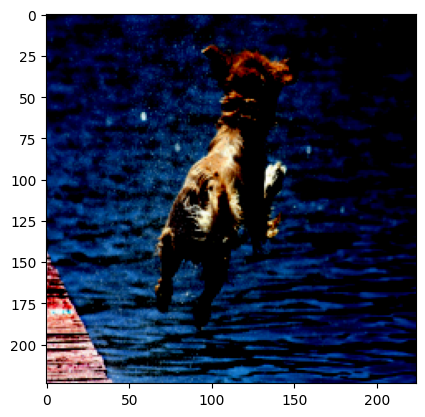

In [ ]:
import matplotlib.pyplot as plt
import math
import random
transformed_image, y = train_dataset[2875]
transformed_image.shape, y.shape

plt.imshow(transformed_image.permute(1,2,0))
print('\nTokenized text:', y)

for i in y:
    print(train_dataset.vocab.itos[int(i)],end=" ")

# Building Model

In [29]:
class RESNET(nn.Module):
    def __init__(self, embed_size, freeze = True):
        super(RESNET, self).__init__()
        self.resnet = models.resnet18(weights = "DEFAULT")
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.dropout= nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
        for param in self.resnet.parameters():
          if freeze:
            param.requires_grad = False
          else:
            param.requires_grad = True

        self.resnet.fc.weight.requires_grad = True
        self.resnet.fc.bias.requires_grad = True

    def forward(self, x):
        y = self.resnet(x)
        y = self.relu(y)
        y = self.dropout(y)
        return y
        

In [30]:
class GENERATOR(nn.Module):
    def __init__(self, embed_size,vocab_size, hidden_size, num_layers):
        super(GENERATOR, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, features, caption):
        embeddings = self.dropout(self.embedding(caption))
        embeddings = torch.cat((features.unsqueeze(0),embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [31]:
class FullModel(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_layers, freeze = True):
        super(FullModel, self).__init__()
        self.RESNET = RESNET(embed_size, freeze = freeze)
        self.GENERATOR = GENERATOR(embed_size, vocab_size, hidden_size, num_layers)
    
    def forward(self, images, caption):
        x = self.RESNET(images)
        x = self.GENERATOR(x, caption)
        return x
    
    def captionImage(self, image, vocabulary, maxlength=50):
        result_caption = []
        
        with torch.no_grad():
            x = self.RESNET(image).unsqueeze(0)
            states = None
            
            for _ in range(maxlength):
                hiddens, states = self.GENERATOR.lstm(x, states)
                output = self.GENERATOR.linear(hiddens.squeeze(0))
                predicted_index = output.argmax(1)
                result_caption.append(predicted_index.item())
                x = self.GENERATOR.embedding(predicted_index).unsqueeze(0)
                
                if vocabulary.itos[predicted_index.item()] == "<EOS>":
                    break
            caption_list = [vocabulary.itos[i] for i in result_caption]
            caption = ''
            for i in caption_list:
              caption += ' ' + i
        return caption

# Training Freezed

In [ ]:
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
freeze = True

In [ ]:
losses = []
val_losses = []

In [ ]:
import torch.optim as optim 
import torch.optim.lr_scheduler as lr_scheduler
embed_size = 400
hidden_size = 512
num_layers = 2
num_epochs = 15
learning_rate = 0.0016
vocab_size = len(train_dataset.vocab)

In [ ]:
model = FullModel(embed_size=embed_size, hidden_size=hidden_size,vocab_size=vocab_size, num_layers=num_layers, freeze = freeze).to(device=device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


In [ ]:
loss_criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', cooldown = 1,patience = 1, factor = 0.7, min_lr = 5e-6)

## 1st train

In [ ]:
for epoch in range(num_epochs):
    # train
    model.train()
    for idx, (imgs, captions) in enumerate(train_loader):
    
      imgs = imgs.to(device)
      captions = captions.to(device)
      
      score = model(imgs, captions[:-1])

      optimizer.zero_grad()
      loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))   
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1)
      optimizer.step()

    
    # test
    model.eval()
    
    for idx, (imgs, captions) in enumerate(test_loader):
    
      imgs = imgs.to(device)
      captions = captions.to(device)
      score = model(imgs, captions[:-1])
      
      val_loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))

    losses.append(loss)
    val_losses.append(val_loss)
    print(f"epoch {epoch+1}: Loss: {loss}, Val loss: {val_loss}  lr = {optimizer.param_groups[0]['lr']}")
    scheduler.step()

epoch 1: Loss: 2.3677120208740234, Val loss: 2.489642858505249  lr = 0.0016
epoch 2: Loss: 2.2184767723083496, Val loss: 3.0100882053375244  lr = 0.0016
epoch 3: Loss: 2.2495172023773193, Val loss: 2.578558921813965  lr = 0.0016
epoch 4: Loss: 2.12850022315979, Val loss: 3.539353609085083  lr = 0.0016
epoch 5: Loss: 2.1527929306030273, Val loss: 2.691818952560425  lr = 0.0016
epoch 6: Loss: 1.8452240228652954, Val loss: 2.439159870147705  lr = 0.0008
epoch 7: Loss: 2.0197765827178955, Val loss: 2.7012758255004883  lr = 0.0008
epoch 8: Loss: 1.9666227102279663, Val loss: 3.494765520095825  lr = 0.0008
epoch 9: Loss: 1.7885440587997437, Val loss: 3.8531477451324463  lr = 0.0008


KeyboardInterrupt: ignored

## 2nd train

In [ ]:
for epoch in range(num_epochs):
    # train
    model.train()
    for idx, (imgs, captions) in enumerate(train_loader):
    
      imgs = imgs.to(device)
      captions = captions.to(device)
      
      score = model(imgs, captions[:-1])

      optimizer.zero_grad()
      loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))   
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1)
      optimizer.step()

    
    # test
    model.eval()
    
    for idx, (imgs, captions) in enumerate(test_loader):
    
      imgs = imgs.to(device)
      captions = captions.to(device)
      score = model(imgs, captions[:-1])
      
      val_loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))

    losses.append(loss)
    val_losses.append(val_loss)
    print(f"epoch {epoch+1}: Loss: {loss}, Val loss: {val_loss}  lr = {optimizer.param_groups[0]['lr']}")
    scheduler.step()

epoch 1: Loss: 1.781926155090332, Val loss: 3.9675369262695312  lr = 0.0016
epoch 2: Loss: 2.389904737472534, Val loss: 2.57558012008667  lr = 0.0016
epoch 3: Loss: 1.6431033611297607, Val loss: 3.565300941467285  lr = 0.0016
epoch 4: Loss: 1.8497958183288574, Val loss: 3.3672149181365967  lr = 0.0016
epoch 5: Loss: 1.5359861850738525, Val loss: 3.930727481842041  lr = 0.0016
epoch 6: Loss: 1.6870150566101074, Val loss: 3.678687810897827  lr = 0.0008
epoch 7: Loss: 1.6601074934005737, Val loss: 3.5462327003479004  lr = 0.0008
epoch 8: Loss: 1.4355162382125854, Val loss: 3.4679064750671387  lr = 0.0008
epoch 9: Loss: 1.4570419788360596, Val loss: 2.660299777984619  lr = 0.0008
epoch 10: Loss: 1.468469500541687, Val loss: 3.511680841445923  lr = 0.0008
epoch 11: Loss: 1.4305990934371948, Val loss: 4.124610900878906  lr = 0.0004
epoch 12: Loss: 1.4958959817886353, Val loss: 4.373839855194092  lr = 0.0004


OutOfMemoryError: ignored

## save load

### save

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
os.mkdir('/content/saved_model/')

In [ ]:
torch.save(model.state_dict(),'/content/saved_model/saved_model512')

In [ ]:
!cp -av '/content/saved_model/saved_model512' '/content/drive/MyDrive'

'/content/saved_model/saved_model512' -> '/content/drive/MyDrive/saved_model512'


### load

In [ ]:
!gdown 1HSv8wnUnI282MldDU5d2cnoEhApAwc0d

Downloading...
From: https://drive.google.com/uc?id=1HSv8wnUnI282MldDU5d2cnoEhApAwc0d
To: /content/saved_model512
100% 1.39G/1.39G [00:15<00:00, 88.5MB/s]


In [ ]:
model.load_state_dict(torch.load('/content/saved_model512'))
model.eval()

CNN2RNN(
  (encoderCNN): encoderCNN(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

# Evaluating Freezed

 <SOS> a man in a black shirt is standing next to a woman and a table <EOS>


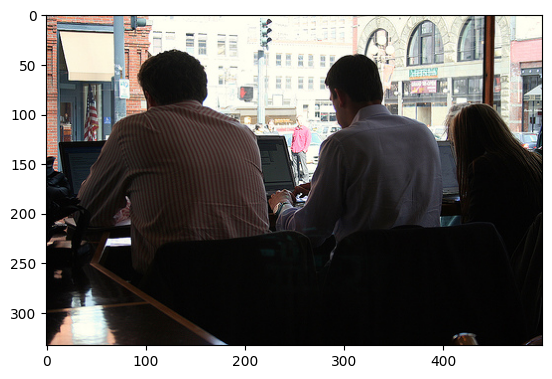

In [ ]:
import random
rand = random.randint(0,1000)
image_path = g("/content/images/test/*")[rand]

img = Image.open(image_path)


plt.imshow(img)
img = transform(img).unsqueeze(0)


image_input = img.to(device=device) # check here
model.eval()
print(model.captionImage(image=image_input, vocabulary=test_dataset.vocab))

 <SOS> a man is standing on a rock in front of a mountainous area <EOS>


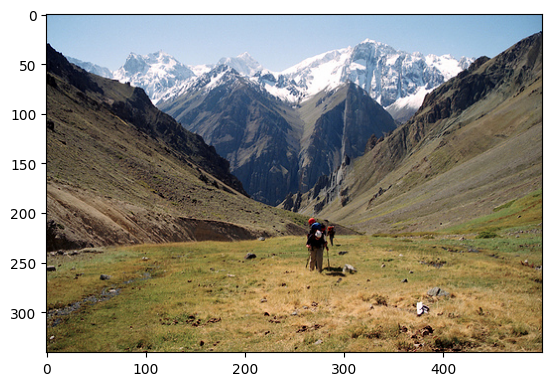

In [ ]:
import random
rand = random.randint(0,1000)
image_path = g("/content/images/test/*")[rand]

img = Image.open(image_path)


plt.imshow(img)
img = transform(img).unsqueeze(0)


image_input = img.to(device=device) # check here
model.eval()
print(model.captionImage(image=image_input, vocabulary=test_dataset.vocab))

 <SOS> a black dog is jumping over a log <EOS>


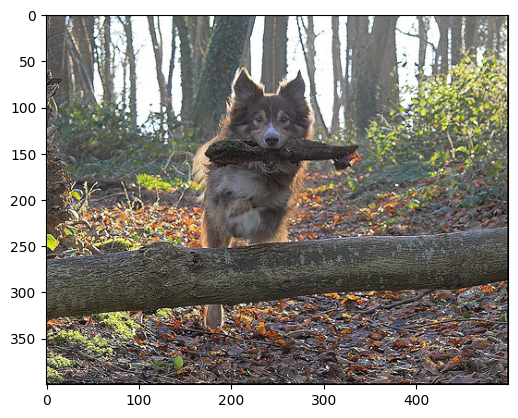

In [ ]:
import random
rand = random.randint(0,1000)
image_path = g("/content/images/test/*")[rand]

img = Image.open(image_path)


plt.imshow(img)
img = transform(img).unsqueeze(0)


image_input = img.to(device=device) # check here
model.eval()
print(model.captionImage(image=image_input, vocabulary=test_dataset.vocab))

In [32]:
losses = [3.4354562759399414, 2.8609840869903564, 2.561616897583008, 2.580446720123291, 2.3677120208740234, 2.2184767723083496, 2.2495172023773193, 2.12850022315979,
          2.1527929306030273, 1.8452240228652954, 2.0197765827178955, 1.9666227102279663, 1.7885440587997437, 1.781926155090332, 2.389904737472534, 1.6431033611297607,
          1.8497958183288574, 1.5359861850738525, 1.6870150566101074, 1.6601074934005737, 1.4355162382125854, 1.4570419788360596, 1.468469500541687, 1.4305990934371948,
          1.4958959817886353]
val_losses = [2.4999022483825684, 3.0778305530548096, 3.0194756984710693, 2.5601108074188232, 2.489642858505249, 3.0100882053375244, 2.578558921813965, 3.539353609085083,
              2.691818952560425, 2.439159870147705, 2.7012758255004883, 3.494765520095825, 3.8531477451324463, 3.9675369262695312, 2.57558012008667, 3.565300941467285,
              3.3672149181365967, 3.930727481842041, 3.678687810897827, 3.5462327003479004, 3.4679064750671387, 2.660299777984619, 3.511680841445923, 4.124610900878906,
              4.373839855194092]

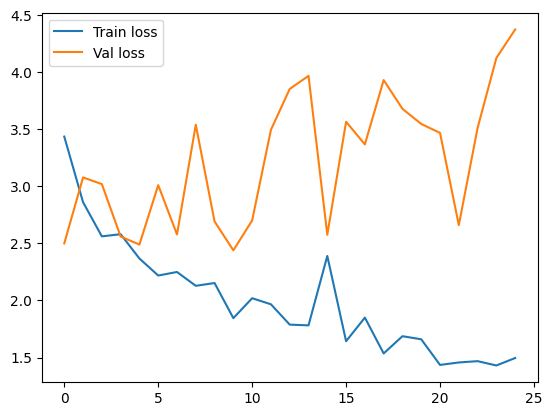

In [33]:
plt.plot(losses)
plt.plot(val_losses)

plt.legend(['Train loss', 'Val loss'])

In [ ]:
epoch 1: Loss: 3.4354562759399414, Val loss: 2.4999022483825684  lr = 0.0016
epoch 2: Loss: 2.8609840869903564, Val loss: 3.0778305530548096  lr = 0.0016
epoch 3: Loss: 2.561616897583008, Val loss: 3.0194756984710693  lr = 0.0016
epoch 4: Loss: 2.580446720123291, Val loss: 2.5601108074188232  lr = 0.0016 # 2 layer 512 train (1st)

In [ ]:
epoch 1: Loss: 2.3677120208740234, Val loss: 2.489642858505249  lr = 0.0016
epoch 2: Loss: 2.2184767723083496, Val loss: 3.0100882053375244  lr = 0.0016
epoch 3: Loss: 2.2495172023773193, Val loss: 2.578558921813965  lr = 0.0016
epoch 4: Loss: 2.12850022315979, Val loss: 3.539353609085083  lr = 0.0016
epoch 5: Loss: 2.1527929306030273, Val loss: 2.691818952560425  lr = 0.0016
epoch 6: Loss: 1.8452240228652954, Val loss: 2.439159870147705  lr = 0.0008
epoch 7: Loss: 2.0197765827178955, Val loss: 2.7012758255004883  lr = 0.0008
epoch 8: Loss: 1.9666227102279663, Val loss: 3.494765520095825  lr = 0.0008
epoch 9: Loss: 1.7885440587997437, Val loss: 3.8531477451324463  lr = 0.0008  # 2 layer 512 train (2nd)

In [ ]:
epoch 1: Loss: 1.781926155090332, Val loss: 3.9675369262695312  lr = 0.0016
epoch 2: Loss: 2.389904737472534, Val loss: 2.57558012008667  lr = 0.0016
epoch 3: Loss: 1.6431033611297607, Val loss: 3.565300941467285  lr = 0.0016
epoch 4: Loss: 1.8497958183288574, Val loss: 3.3672149181365967  lr = 0.0016
epoch 5: Loss: 1.5359861850738525, Val loss: 3.930727481842041  lr = 0.0016
epoch 6: Loss: 1.6870150566101074, Val loss: 3.678687810897827  lr = 0.0008
epoch 7: Loss: 1.6601074934005737, Val loss: 3.5462327003479004  lr = 0.0008
epoch 8: Loss: 1.4355162382125854, Val loss: 3.4679064750671387  lr = 0.0008
epoch 9: Loss: 1.4570419788360596, Val loss: 2.660299777984619  lr = 0.0008
epoch 10: Loss: 1.468469500541687, Val loss: 3.511680841445923  lr = 0.0008
epoch 11: Loss: 1.4305990934371948, Val loss: 4.124610900878906  lr = 0.0004
epoch 12: Loss: 1.4958959817886353, Val loss: 4.373839855194092  lr = 0.0004  # 2 layer 512 train (3rd)

In [ ]:
epoch 1: Loss: 3.2353382110595703, Val loss: 3.1381492614746094  lr = 0.002
epoch 2: Loss: 2.713606834411621, Val loss: 2.9926624298095703  lr = 0.002
epoch 3: Loss: 2.906226873397827, Val loss: 2.5808844566345215  lr = 0.002
epoch 4: Loss: 2.7464990615844727, Val loss: 2.5069122314453125  lr = 0.002
epoch 5: Loss: 2.314649820327759, Val loss: 2.379800796508789  lr = 0.002
epoch 6: Loss: 3.0315730571746826, Val loss: 2.826636791229248  lr = 0.001
epoch 7: Loss: 2.3177711963653564, Val loss: 2.776205062866211  lr = 0.001
epoch 8: Loss: 2.524712562561035, Val loss: 2.5806496143341064  lr = 0.001
epoch 9: Loss: 2.362344741821289, Val loss: 2.5183284282684326  lr = 0.001
epoch 10: Loss: 2.325807809829712, Val loss: 2.744241237640381  lr = 0.001
epoch 11: Loss: 2.3980934619903564, Val loss: 2.7441866397857666  lr = 0.0005
epoch 12: Loss: 2.2522454261779785, Val loss: 3.0652568340301514  lr = 0.0005
epoch 13: Loss: 2.4245591163635254, Val loss: 3.528259515762329  lr = 0.0005
epoch 14: Loss: 2.1388473510742188, Val loss: 2.98331880569458  lr = 0.0005   # 2 layer 256 train (1st)

In [ ]:
epoch 1: Loss: 2.0521976947784424, Val loss: 3.399665594100952  lr = 0.0004
epoch 2: Loss: 2.29612135887146, Val loss: 2.4674155712127686  lr = 0.0004
epoch 3: Loss: 1.9666047096252441, Val loss: 3.043260335922241  lr = 0.0004
epoch 4: Loss: 2.256849765777588, Val loss: 3.533658266067505  lr = 0.0004
epoch 5: Loss: 2.1946699619293213, Val loss: 3.2496256828308105  lr = 0.0004
epoch 6: Loss: 2.175788640975952, Val loss: 3.0020592212677  lr = 0.0002
epoch 7: Loss: 2.0162956714630127, Val loss: 4.642874240875244  lr = 0.0002
epoch 8: Loss: 2.1180925369262695, Val loss: 2.6148433685302734  lr = 0.0002
epoch 9: Loss: 2.054640054702759, Val loss: 2.8365838527679443  lr = 0.0002
epoch 10: Loss: 1.7400660514831543, Val loss: 2.4889187812805176  lr = 0.0002
epoch 11: Loss: 2.214327335357666, Val loss: 3.3054046630859375  lr = 0.0001  # 2 layer 256 train (2nd)

In [ ]:
epoch 1: Loss: 3.0594818592071533, Val loss: 2.94497013092041  lr = 0.004
epoch 2: Loss: 2.648362398147583, Val loss: 2.8463587760925293  lr = 0.004
epoch 3: Loss: 2.7439146041870117, Val loss: 2.847282648086548  lr = 0.004
epoch 4: Loss: 2.9586899280548096, Val loss: 3.4359867572784424  lr = 0.004
epoch 5: Loss: 2.540327310562134, Val loss: 2.508587598800659  lr = 0.004
epoch 6: Loss: 2.638699531555176, Val loss: 2.607152223587036  lr = 0.002
epoch 7: Loss: 2.4158756732940674, Val loss: 2.4088313579559326  lr = 0.002
epoch 8: Loss: 2.342791795730591, Val loss: 2.2093358039855957  lr = 0.002
epoch 9: Loss: 2.819110155105591, Val loss: 2.9413371086120605  lr = 0.002
epoch 10: Loss: 2.236976146697998, Val loss: 2.872769832611084  lr = 0.002
epoch 11: Loss: 2.2556610107421875, Val loss: 3.077732801437378  lr = 0.001
epoch 12: Loss: 2.54453444480896, Val loss: 2.7277936935424805  lr = 0.001
epoch 13: Loss: 2.190171003341675, Val loss: 3.039320945739746  lr = 0.001
epoch 14: Loss: 2.4717109203338623, Val loss: 2.8341479301452637  lr = 0.001
epoch 15: Loss: 1.9958966970443726, Val loss: 3.381221055984497  lr = 0.001 # 1 layer 512 train(1st)

# Train Unfreezed

In [13]:
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
freeze = False

In [14]:
losses = []
val_losses = []

In [34]:
import torch.optim as optim 
import torch.optim.lr_scheduler as lr_scheduler
embed_size = 400
hidden_size = 512
num_layers = 2
num_epochs = 15
learning_rate = 0.0016
vocab_size = len(train_dataset.vocab)

In [35]:
model = FullModel(embed_size=embed_size, hidden_size=hidden_size,vocab_size=vocab_size, num_layers=num_layers, freeze = freeze).to(device=device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 367MB/s]


In [36]:
loss_criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', cooldown = 1,patience = 1, factor = 0.7, min_lr = 5e-6)

## 1st train

In [ ]:
for epoch in range(num_epochs):
    # train
    model.train()
    for idx, (imgs, captions) in enumerate(train_loader):
    
      imgs = imgs.to(device)
      captions = captions.to(device)
      
      score = model(imgs, captions[:-1])

      optimizer.zero_grad()
      loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))   
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1)
      optimizer.step()

    
    # test
    model.eval()
    
    for idx, (imgs, captions) in enumerate(test_loader):
    
      imgs = imgs.to(device)
      captions = captions.to(device)
      score = model(imgs, captions[:-1])
      
      val_loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))

    losses.append(loss)
    val_losses.append(val_loss)
    print(f"epoch {epoch+1}: Loss: {loss}, Val loss: {val_loss}  lr = {optimizer.param_groups[0]['lr']}")
    scheduler.step()

epoch 1: Loss: 3.185434579849243, Val loss: 3.1614012718200684  lr = 0.0016
epoch 2: Loss: 3.009843349456787, Val loss: 2.6160454750061035  lr = 0.0016
epoch 3: Loss: 2.7490015029907227, Val loss: 2.4433865547180176  lr = 0.0016
epoch 4: Loss: 2.493272304534912, Val loss: 2.6387338638305664  lr = 0.0016
epoch 5: Loss: 2.56970477104187, Val loss: 2.6180613040924072  lr = 0.0016
epoch 6: Loss: 2.5964372158050537, Val loss: 2.5481772422790527  lr = 0.0008


OutOfMemoryError: ignored

## 2nd train

In [ ]:
for epoch in range(num_epochs):
    # train
    model.train()
    for idx, (imgs, captions) in enumerate(train_loader):
    
      imgs = imgs.to(device)
      captions = captions.to(device)
      
      score = model(imgs, captions[:-1])

      optimizer.zero_grad()
      loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))   
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1)
      optimizer.step()

    
    # test
    model.eval()
    
    for idx, (imgs, captions) in enumerate(test_loader):
    
      imgs = imgs.to(device)
      captions = captions.to(device)
      score = model(imgs, captions[:-1])
      
      val_loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))

    losses.append(loss)
    val_losses.append(val_loss)
    print(f"epoch {epoch+1}: Loss: {loss}, Val loss: {val_loss}  lr = {optimizer.param_groups[0]['lr']}")
    scheduler.step()

epoch 1: Loss: 2.655750036239624, Val loss: 2.524280548095703  lr = 0.0016
epoch 2: Loss: 2.437602996826172, Val loss: 2.3948285579681396  lr = 0.0016
epoch 3: Loss: 2.0632100105285645, Val loss: 2.6317553520202637  lr = 0.0016
epoch 4: Loss: 2.3105695247650146, Val loss: 3.04498028755188  lr = 0.0016
epoch 5: Loss: 1.9640147686004639, Val loss: 2.377674102783203  lr = 0.0016


OutOfMemoryError: ignored

## 3rd train

In [48]:
for epoch in range(num_epochs):
    # train
    model.train()
    for idx, (imgs, captions) in enumerate(train_loader):
    
      imgs = imgs.to(device)
      captions = captions.to(device)
      
      score = model(imgs, captions[:-1])

      optimizer.zero_grad()
      loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))   
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1)
      optimizer.step()

    
    # test
    model.eval()
    
    for idx, (imgs, captions) in enumerate(test_loader):
    
      imgs = imgs.to(device)
      captions = captions.to(device)
      score = model(imgs, captions[:-1])
      
      val_loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))

    losses.append(loss)
    val_losses.append(val_loss)
    print(f"epoch {epoch+1}: Loss: {loss}, Val loss: {val_loss}  lr = {optimizer.param_groups[0]['lr']}")
    scheduler.step()

epoch 1: Loss: 2.070683479309082, Val loss: 3.1334774494171143  lr = 0.0016
epoch 2: Loss: 1.949273705482483, Val loss: 3.149609088897705  lr = 0.0016


KeyboardInterrupt: ignored

## save load

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

### save

In [56]:
os.mkdir('/content/saved_model/')

In [57]:
torch.save(model.state_dict(),'/content/saved_model/saved_model512resnet')

In [58]:
!cp -av '/content/saved_model/saved_model512resnet' '/content/drive/MyDrive'

'/content/saved_model/saved_model512resnet' -> '/content/drive/MyDrive/saved_model512resnet'


### load

In [40]:
!gdown 1OCTWRM6nsngsgZs878tEUaIUr9yQxCss

Downloading...
From: https://drive.google.com/uc?id=1OCTWRM6nsngsgZs878tEUaIUr9yQxCss
To: /content/saved_model512resnet
100% 1.39G/1.39G [00:19<00:00, 71.1MB/s]


In [41]:
model.load_state_dict(torch.load('/content/saved_model512resnet'))
model.eval()

FullModel(
  (RESNET): RESNET(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2

# Evaluating Unfreezed

 <SOS> a man in a red shirt is standing in front of a white building <EOS>


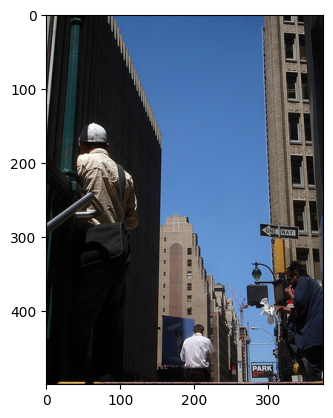

In [75]:
import random
rand = random.randint(0,1000)
image_path = g("/content/images/test/*")[rand]

img = Image.open(image_path)


plt.imshow(img)
img = transform(img).unsqueeze(0)


image_input = img.to(device=device) # check here
model.eval()
print(model.captionImage(image=image_input, vocabulary=test_dataset.vocab))

 <SOS> a man in a red shirt is standing in front of a white building <EOS>


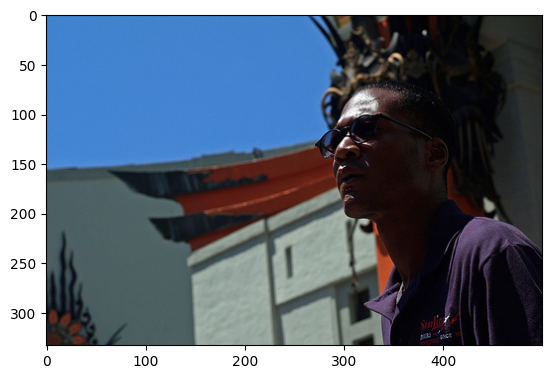

In [49]:
import random
rand = random.randint(0,1000)
image_path = g("/content/images/test/*")[rand]

img = Image.open(image_path)


plt.imshow(img)
img = transform(img).unsqueeze(0)


image_input = img.to(device=device) # check here
model.eval()
print(model.captionImage(image=image_input, vocabulary=test_dataset.vocab))

 <SOS> a dog is running through the snow <EOS>


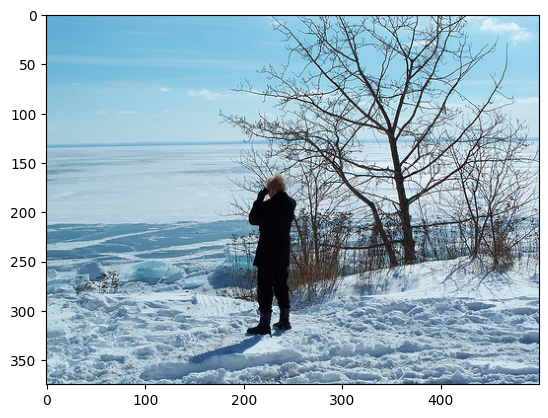

In [53]:
import random
rand = random.randint(0,1000)
image_path = g("/content/images/test/*")[rand]

img = Image.open(image_path)


plt.imshow(img)
img = transform(img).unsqueeze(0)


image_input = img.to(device=device) # check here
model.eval()
print(model.captionImage(image=image_input, vocabulary=test_dataset.vocab))

In [ ]:
epoch 1: Loss: 3.185434579849243, Val loss: 3.1614012718200684  lr = 0.0016
epoch 2: Loss: 3.009843349456787, Val loss: 2.6160454750061035  lr = 0.0016
epoch 3: Loss: 2.7490015029907227, Val loss: 2.4433865547180176  lr = 0.0016
epoch 4: Loss: 2.493272304534912, Val loss: 2.6387338638305664  lr = 0.0016
epoch 5: Loss: 2.56970477104187, Val loss: 2.6180613040924072  lr = 0.0016
epoch 6: Loss: 2.5964372158050537, Val loss: 2.5481772422790527  lr = 0.0008  # 1st train

In [ ]:
epoch 1: Loss: 2.655750036239624, Val loss: 2.524280548095703  lr = 0.0016
epoch 2: Loss: 2.437602996826172, Val loss: 2.3948285579681396  lr = 0.0016
epoch 3: Loss: 2.0632100105285645, Val loss: 2.6317553520202637  lr = 0.0016
epoch 4: Loss: 2.3105695247650146, Val loss: 3.04498028755188  lr = 0.0016
epoch 5: Loss: 1.9640147686004639, Val loss: 2.377674102783203  lr = 0.0016  # 2nd train

In [ ]:
epoch 1: Loss: 2.070683479309082, Val loss: 3.1334774494171143  lr = 0.0016
epoch 2: Loss: 1.949273705482483, Val loss: 3.149609088897705  lr = 0.0016 # 3rd train

In [69]:
losses = [3.185434579849243, 3.009843349456787, 2.7490015029907227, 2.493272304534912, 2.56970477104187,
          2.5964372158050537, 2.655750036239624, 2.437602996826172, 
          2.0632100105285645, 2.3105695247650146, 1.9640147686004639, 2.070683479309082, 1.949273705482483]
val_losses = [3.1614012718200684, 2.6160454750061035, 2.4433865547180176, 2.6387338638305664,
              2.6180613040924072, 2.5481772422790527, 2.524280548095703, 
              2.3948285579681396, 2.6317553520202637, 3.04498028755188, 2.377674102783203, 3.1334774494171143,
              3.149609088897705]

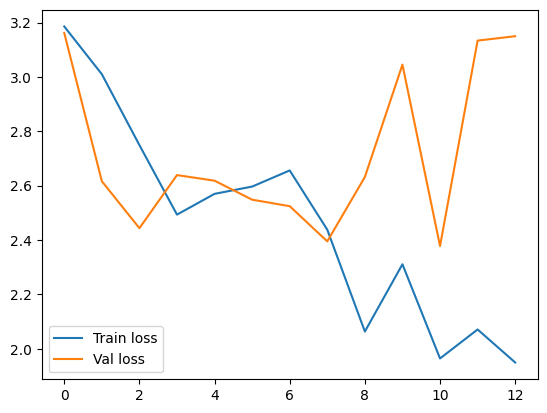

In [70]:
plt.plot(losses)
plt.plot(val_losses)

plt.legend(['Train loss', 'Val loss'])